## Preparing Data

### Read data

In [1]:
import os

images_dir = '/mnt/0D6BEAD6291820B7/Wilgo/Datasets/sugar_beets/rgb'
masks_dir = '/mnt/0D6BEAD6291820B7/Wilgo/Datasets/sugar_beets/labels'


def get_file_number(filename):
    try:
        number_str = filename.split('_')[1].split('.')[0]
        return int(number_str)
    except (IndexError, ValueError):
        return float('inf')

try:
    image_filenames = [f for f in os.listdir(images_dir) if f.endswith('.png')]
    mask_filenames = [f for f in os.listdir(masks_dir) if f.endswith('.png')]

    image_filenames.sort(key=get_file_number)
    mask_filenames.sort(key=get_file_number)

    image_paths = [os.path.join(images_dir, f) for f in image_filenames]
    mask_paths = [os.path.join(masks_dir, f) for f in mask_filenames]

    if len(image_paths) == len(mask_paths) and len(image_paths) > 0:
        print(f"✅ Success! Found and paired {len(image_paths)} image/mask pairs.")
        
        print("\nChecking the first 5 ordered pairs:")
        for i in range(min(5, len(image_paths))):
            img_name = os.path.basename(image_paths[i])
            mask_name = os.path.basename(mask_paths[i])
            print(f"  Pair {i+1}: Image: {img_name:<12} --- Mask: {mask_name}")
            
    elif len(image_paths) != len(mask_paths):
        print(f"❌ Error: The number of images ({len(image_paths)}) and masks ({len(mask_paths)}) is different.")
    else:
        print("❌ Error: No .png files were found in the directories.")

except FileNotFoundError as e:
    print(f"❌ Directory Error: Could not find the specified path. Please check the paths.")
    print(e)

✅ Success! Found and paired 283 image/mask pairs.

Checking the first 5 ordered pairs:
  Pair 1: Image: rgb_01.png   --- Mask: label_01.png
  Pair 2: Image: rgb_02.png   --- Mask: label_02.png
  Pair 3: Image: rgb_03.png   --- Mask: label_03.png
  Pair 4: Image: rgb_04.png   --- Mask: label_04.png
  Pair 5: Image: rgb_05.png   --- Mask: label_05.png


### Create Masks

In [2]:
import cv2
import numpy as np
from tqdm import tqdm

COLOR_MAP_BGR = {
    'background': [0, 0, 0],
    'class_1':    [0, 0, 255],      
    'class_2':    [255, 50, 0],    
    'class_3_a':  [0, 150, 255],    
    'class_3_b':  [0, 200, 255]     
}

def convert_mask_to_class_fast(mask_bgr):
    mask_class = np.zeros(mask_bgr.shape[:2], dtype=np.uint8)
    
    mask_class[np.all(mask_bgr == COLOR_MAP_BGR['class_1'], axis=-1)] = 1
    mask_class[np.all(mask_bgr == COLOR_MAP_BGR['class_2'], axis=-1)] = 2
    mask_class[np.all(mask_bgr == COLOR_MAP_BGR['class_3_a'], axis=-1)] = 3
    mask_class[np.all(mask_bgr == COLOR_MAP_BGR['class_3_b'], axis=-1)] = 3
    
    return mask_class

masks_class_processed = []

for path in tqdm(mask_paths, desc="Processing Masks"):
    mask_bgr = cv2.imread(path)
    
    if mask_bgr is None:
        print(f"Warning: Could not read mask at {path}")
        continue
        
    mask_class = convert_mask_to_class_fast(mask_bgr)
    masks_class_processed.append(mask_class)

print(f"\n✅ Successfully processed {len(masks_class_processed)} masks.")

if masks_class_processed:
    unique_values = np.unique(masks_class_processed[0])
    print(f"Unique class IDs in the first processed mask: {unique_values}")

Processing Masks: 100%|██████████| 283/283 [00:40<00:00,  6.95it/s]


✅ Successfully processed 283 masks.
Unique class IDs in the first processed mask: [0 1 2 3]


### Plot Images and Masks

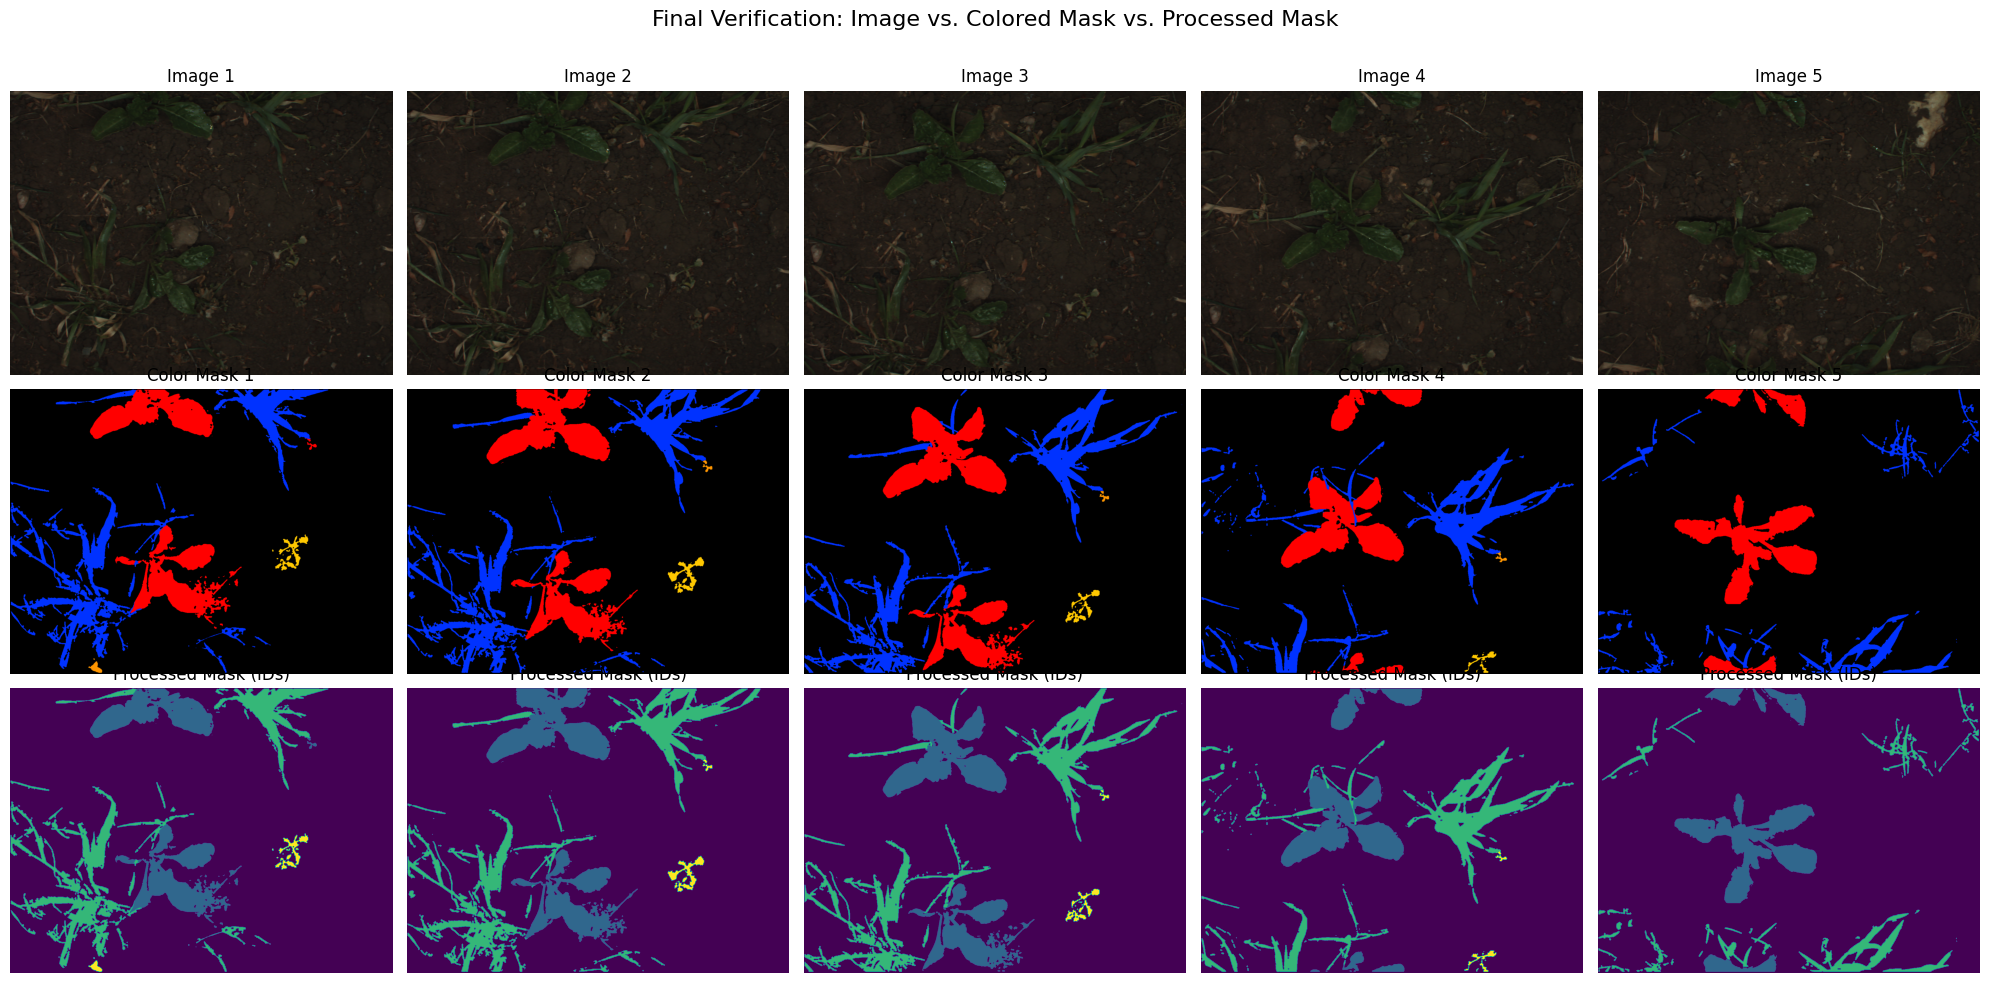

In [3]:
import matplotlib.pyplot as plt
import cv2

n_examples = 5
if len(image_paths) < n_examples:
    n_examples = len(image_paths)

fig, axs = plt.subplots(3, n_examples, figsize=(20, 10))
fig.suptitle("Final Verification: Image vs. Colored Mask vs. Processed Mask", fontsize=16)

for i in range(n_examples):
    img_bgr = cv2.imread(image_paths[i])
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    color_mask_bgr = cv2.imread(mask_paths[i])
    color_mask_rgb = cv2.cvtColor(color_mask_bgr, cv2.COLOR_BGR2RGB)
    
    processed_mask = masks_class_processed[i]

    axs[0, i].imshow(img_rgb)
    axs[0, i].set_title(f"Image {i+1}")
    axs[0, i].axis('off')

    axs[1, i].imshow(color_mask_rgb)
    axs[1, i].set_title(f"Color Mask {i+1}")
    axs[1, i].axis('off')

    axs[2, i].imshow(processed_mask, cmap='viridis', vmin=0, vmax=3)
    axs[2, i].set_title(f"Processed Mask (IDs)")
    axs[2, i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Class Imbalance Analysis

Analyzing Class Distribution: 100%|██████████| 283/283 [00:03<00:00, 78.44it/s]


--- Overall Class Distribution in the Complete Dataset ---
Class 0:  333,926,020 pixels (94.2501%)
Class 1:   14,623,075 pixels (4.1273%)
Class 2:    5,189,569 pixels (1.4647%)
Class 3:      559,224 pixels (0.1578%)

Total Pixels Analyzed: 354,297,888


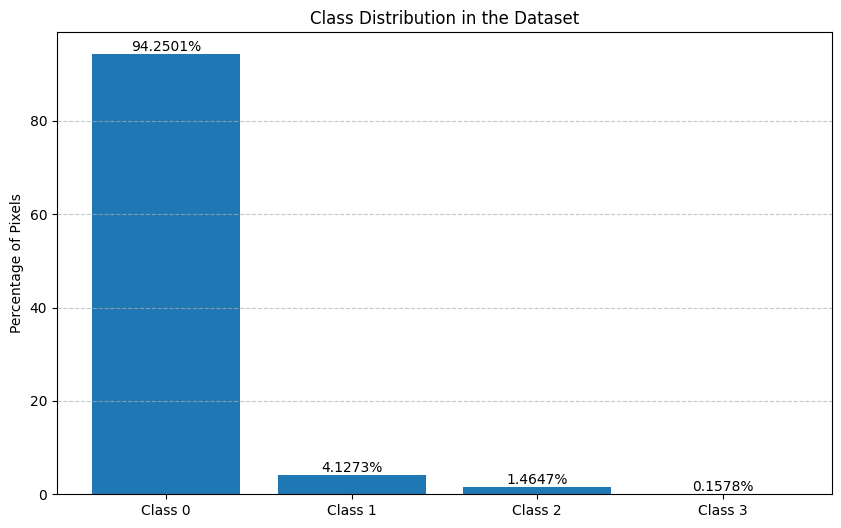

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

class_counts = defaultdict(int)
total_pixels = 0
num_classes = 4 

for mask in tqdm(masks_class_processed, desc="Analyzing Class Distribution"):
    total_pixels += mask.size
    
    unique, counts = np.unique(mask, return_counts=True)
    
    for cls, count in zip(unique, counts):
        class_counts[cls] += count

print("\n--- Overall Class Distribution in the Complete Dataset ---")
class_percentages = {}
for i in range(num_classes):
    count = class_counts[i]
   
    percent = (count / total_pixels) * 100
    class_percentages[i] = percent
    print(f"Class {i}: {count:12,} pixels ({percent:.4f}%)")

print(f"\nTotal Pixels Analyzed: {total_pixels:,}")

class_labels = [f'Class {i}' for i in sorted(class_percentages.keys())]
percentages = [class_percentages[key] for key in sorted(class_percentages.keys())]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(class_labels, percentages)


ax.set_ylabel('Percentage of Pixels')
ax.set_title('Class Distribution in the Dataset')
ax.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}%', va='bottom', ha='center')

plt.show()


## Dataset and Traning

### Definitions and Transformations

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2


class SugarBeetDataset(Dataset):
    def __init__(self, image_paths, masks, transforms=None):
        self.image_paths = image_paths
        self.masks = masks
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = self.masks[idx]
        
        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        return image, mask

train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(p=0.2),
    A.Resize(height=512, width=512, interpolation=cv2.INTER_NEAREST),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_test_transforms = A.Compose([
    A.Resize(height=512, width=512, interpolation=cv2.INTER_NEAREST),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

### Split Datasets and Create Dataloaders

In [12]:
train_val_paths, test_paths, train_val_masks, test_masks = train_test_split(
    image_paths, masks_class_processed, test_size=0.15, random_state=42
)

train_paths, val_paths, train_masks, val_masks = train_test_split(
    train_val_paths, train_val_masks, test_size=0.15, random_state=42 
)

train_dataset = SugarBeetDataset(train_paths, train_masks, transforms=train_transforms)
val_dataset = SugarBeetDataset(val_paths, val_masks, transforms=val_test_transforms)
test_dataset = SugarBeetDataset(test_paths, test_masks, transforms=val_test_transforms)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

BATCH_SIZE = 4

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=4,   
    pin_memory=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"\nDataLoaders successfully created!")
print("\nExample of a batch from the train_loader:")
for images, masks in train_loader:
    print(f"Batch size: {images.shape[0]}")
    print(f"Image shape: {images.shape[1:]} (C, H, W)")
    print(f"Mask shape: {masks.shape[1:]} (H, W)")
    break

Training set size: 204
Validation set size: 36
Test set size: 43

DataLoaders successfully created!

Example of a batch from the train_loader:
Batch size: 4
Image shape: torch.Size([3, 512, 512]) (C, H, W)
Mask shape: torch.Size([512, 512]) (H, W)


### Dataset (Split)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import torchvision.models.segmentation as segmentation
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time
import gc

class PatchDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32) / 255.0
        mask = self.masks[idx].astype(np.int64)
        image = np.transpose(image, (2, 0, 1))
        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.long)

dataset = PatchDataset(all_img, all_mask)


train_size = int(0.7 * len(dataset))
calibration_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - calibration_size
train_dataset, calibration_dataset, test_dataset = random_split(
    dataset, [train_size, calibration_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

calibration_size_A = len(calibration_dataset) // 2
calibration_size_B = len(calibration_dataset) - calibration_size_A
calibration_A, calibration_B = random_split(
    calibration_dataset, [calibration_size_A, calibration_size_B],
    generator=torch.Generator().manual_seed(42)
)

batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
calibration_loader_A = DataLoader(calibration_A, batch_size=batch_size, shuffle=False)
calibration_loader_B = DataLoader(calibration_B, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train: {len(train_dataset)}")
print(f"Calibration A (Validação): {len(calibration_A)}")
print(f"Calibration B (Conformal): {len(calibration_B)}")
print(f"Test: {len(test_dataset)}")

### Model

#### DeepLabV3

In [ ]:
# Modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = segmentation.deeplabv3_mobilenet_v3_large(weights='DEFAULT')
model.classifier[4] = nn.Conv2d(256, 4, kernel_size=(1, 1))
model = model.to(device)

# Loss e otimizador
class_weights = torch.tensor([0.5, 1.0, 2.0, 0.5]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Mixed precision
scaler = torch.cuda.amp.GradScaler()

# Salvar melhor modelo
def save_best_model(model, path, iou_score, best_iou):
    if iou_score > best_iou:
        print(f"New best model! IoU: {iou_score:.4f}")
        torch.save(model.state_dict(), path)
        return iou_score
    return best_iou

# Treinamento usando mixed precision
def train_model(model, train_loader, val_loader, epochs=10):
    best_iou = 0.0
    for epoch in range(epochs):
        print(f"\n=== Epoch {epoch+1}/{epochs} ===")
        model.train()
        train_loss = 0.0
        start_time = time.time()

        for images, masks in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(images)['out']
                loss = criterion(outputs, masks)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()

            # Libera memória
            torch.cuda.empty_cache()
            gc.collect()

        print(f"Training Loss: {train_loss/len(train_loader):.4f}")

        # Validação
        model.eval()
        val_loss = 0.0
        iou_scores = np.zeros(4)
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)['out']
                    loss = criterion(outputs, masks)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                for cls in range(4):
                    intersection = ((preds == cls) & (masks == cls)).sum().item()
                    union = ((preds == cls) | (masks == cls)).sum().item()
                    iou = intersection / union if union != 0 else 0
                    iou_scores[cls] += iou

                torch.cuda.empty_cache()
                gc.collect()

        iou_scores /= len(val_loader)
        mean_iou = np.mean(iou_scores)
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}")
        for cls_idx, iou_score in enumerate(iou_scores):
            print(f"Class {cls_idx} IoU: {iou_score:.4f}")
        print(f"Mean IoU: {mean_iou:.4f}")

        best_iou = save_best_model(model, "best_model.pth", mean_iou, best_iou)

        if device.type == "cuda":
            print(f"GPU memory used: {torch.cuda.memory_allocated() / 1024 ** 2:.2f} MB")

# Rodar treinamento
train_model(model, train_loader, calibration_loader_A, epochs=10)

### Save the logits

In [ ]:
import torch
from tqdm import tqdm

def save_logits_masks_images(model, loader, save_path):
    model.eval()
    all_logits = []
    all_masks = []
    all_images = []

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Saving logits, masks and images"):
            images = images.to(device)
            outputs = model(images)['out']

            all_logits.append(outputs.cpu())
            all_masks.append(masks.cpu())
            all_images.append(images.cpu())

    all_logits = torch.cat(all_logits)
    all_masks = torch.cat(all_masks)
    all_images = torch.cat(all_images)

    save_dict = {
        "logits": all_logits,
        "masks": all_masks,
        "images": all_images
    }

    torch.save(save_dict, save_path)
    print(f"Logits, masks e images have saved at: {save_path}")

model.load_state_dict(torch.load("best_model.pth", weights_only=True))
save_logits_masks_images(model, calibration_loader_B, "calibration_logits.pth")
save_logits_masks_images(model, test_loader, "test_logits.pth")
